# Fig. 7: Freshwater transport terms as a function of latitude

In [1]:
import os
import sys
import cmocean
import numpy as np
import xarray as xr
import warnings
import matplotlib
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')
matplotlib.rc_file('rc_file_paper')
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [3]:
from MOC import approx_lats
from tqdm import notebook
from paths import file_ex_ocn_ctrl, file_ex_ocn_rcp, file_ex_ocn_lpd, path_prace, path_results, file_RMASK_ocn, file_RMASK_ocn_low
from filters import lowpass
from FW_plots import FS_merid_fluxes_plot, FW_merid_fluxes_plot, Atl_lats, mask_Med, get_BS_Med, get_SFWF
from FW_budget import make_SALT_vol_integrals, load_obj, make_Mask, make_SFWF_surface_integrals
from constants import rho_sw  # [kg/m^3]
from timeseries import IterateOutputCESM
from FW_transport import FW_SALT_flux_dataset, sections_low
from xr_regression import xr_lintrend, xr_linear_trend, xr_2D_trends, xr_regression_with_stats
from xr_DataArrays import xr_DZ

file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None


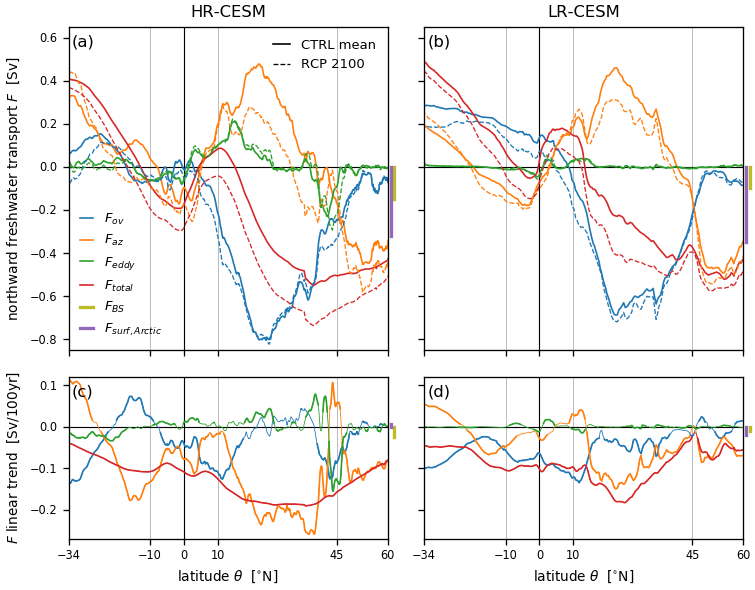

In [4]:
FW_merid_fluxes_plot()

In [5]:
ds_ocn = xr.open_dataset(file_ex_ocn_ctrl, decode_times=False)
ds_low = xr.open_dataset(file_ex_ocn_lpd, decode_times=False)
RMASK_ocn = xr.open_dataarray(file_RMASK_ocn)
RMASK_low = xr.open_dataarray(file_RMASK_ocn_low)
Atl_MASK_ocn = xr.DataArray(np.in1d(RMASK_ocn, [6,8,9]).reshape(RMASK_ocn.shape),
                            dims=RMASK_ocn.dims, coords=RMASK_ocn.coords)
Atl_MASK_low = xr.DataArray(np.in1d(RMASK_low, [6,8,9]).reshape(RMASK_low.shape),
                            dims=RMASK_low.dims, coords=RMASK_low.coords)

In [6]:
# %%time
# # 1min 47s
# def mf_filenames(name,ys,ye,alt=False):
#     return [f'{path_prace}/Mov/{name}_{y:04d}-{m:02d}.nc' for y in range(ys,ye) for m in range(1,13)]

# ds_ctrl_monthly = xr.open_mfdataset(mf_filenames(name='FW_SALT_fluxes_monthly_ctrl', ys=200 , ye=230 ), concat_dim='time', decode_times=False)
# ds_rcp_monthly  = xr.open_mfdataset(mf_filenames(name='FW_SALT_fluxes_monthly_rcp' , ys=2000, ye=2100), concat_dim='time', decode_times=False)
# ds_ctrl_monthly.to_netcdf(f'{path_prace}/Mov/FW_SALT_fluxes_ctrl_0200-0230_monthly_alt.nc')
# ds_rcp_monthly .to_netcdf(f'{path_prace}/Mov/FW_SALT_fluxes_rcp_2000-2100_monthly_alt.nc')

# ds_ctrl_monthly = xr.open_mfdataset(f'{path_prace}/Mov/FW_SALT_fluxes_monthly_ctrl_*_alt.nc', concat_dim='time', decode_times=False)
# ds_rcp_monthly  = xr.open_mfdataset(f'{path_prace}/Mov/FW_SALT_fluxes_monthly_rcp_*_alt.nc' , concat_dim='time', decode_times=False)
# ds_ctrl_monthly.to_netcdf(f'{path_prace}/Mov/FW_SALT_fluxes_ctrl_0200-0230_monthly_alt.nc')
# ds_rcp_monthly .to_netcdf(f'{path_prace}/Mov/FW_SALT_fluxes_rcp_2090-2100_monthly_alt.nc')

In [7]:
# ds_ctrl_monthly = xr.open_mfdataset(f'{path_prace}/Mov/FW_SALT_fluxes_monthly_lpd_*_alt.nc', concat_dim='time', decode_times=False)
# ds_rcp_monthly  = xr.open_mfdataset(f'{path_prace}/Mov/FW_SALT_fluxes_monthly_lr1_*_alt.nc' , concat_dim='time', decode_times=False)
# ds_ctrl_monthly.to_netcdf(f'{path_prace}/Mov/FW_SALT_fluxes_lpd_0500-0530_monthly_alt.nc')
# ds_rcp_monthly .to_netcdf(f'{path_prace}/Mov/FW_SALT_fluxes_lr1_2090-2100_monthly_alt.nc')

In [8]:
# ds_ctrl_monthly = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_ctrl_0200-0230_monthly.nc', decode_times=False)
# ds_rcp_monthly  = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_rcp_2000-2100_monthly.nc' , decode_times=False)
ds_ctrl_monthly = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_ctrl_0200-0230_monthly_alt.nc', decode_times=False)
ds_rcp_monthly  = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_rcp_2090-2100_monthly_alt.nc' , decode_times=False)
ds_lpd_monthly  = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_lpd_0500-0530_monthly.nc' , decode_times=False)
ds_lr1_monthly  = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_lr1_2000-2101_monthly.nc' , decode_times=False)

In [9]:
ds_ctrl_yrly = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_ctrl.nc', decode_times=False).isel(time=slice(200,230))
ds_lpd_yrly  = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_lpd.nc' , decode_times=False).isel(time=slice(500-154,530-154))
ds_rcp_yrly  = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_rcp.nc' , decode_times=False)
ds_lr1_yrly  = xr.open_dataset(f'{path_prace}/Mov/FW_SALT_fluxes_lr1.nc' , decode_times=False)

file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None
file does not yet exist; calculating it now:
  None


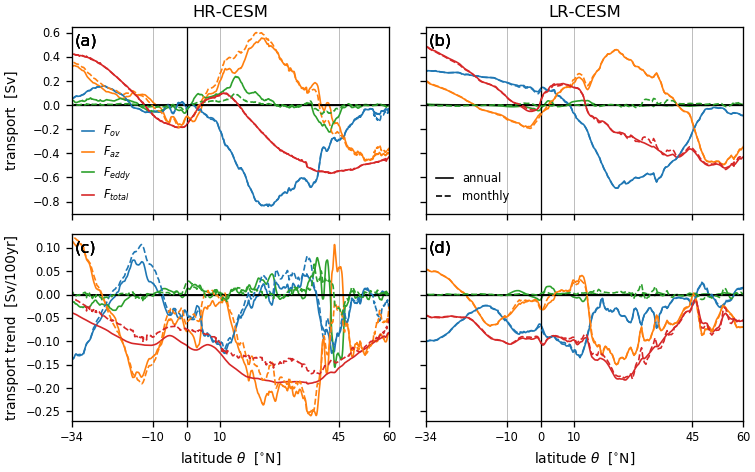

In [10]:
ds_rcp_monthly_ = xr.merge([ds_rcp_monthly,ds_ctrl_monthly.assign_coords(time=ds_ctrl_monthly.time.values+1800*365).isel(time=slice(0,120))])

f, ax = plt.subplots(2,2, figsize=(6.4,4), sharey='row', sharex='col')

for i in range(2):
    ax[1,i].set_xlabel(r'latitude $\theta$  [$\!^\circ\!$N]')
    ax[i,0].set_ylabel(['transport  [Sv]','transport trend  [Sv/100yr]'][i])

for i, avg in enumerate(['yrly', 'monthly']):
    ls =['-','--'][i]
    for j, sim in enumerate(['HR-CESM', 'LR-CESM']):
        lats = Atl_lats(['HIGH','LOW'][j])
        for k, cvr in enumerate(['CTRL','RCP']):
            ax[k,j].axhline(0, c='k', lw=.7)#, zorder=1)
            ax[k,j].axvline(0, c='k', lw=.7)#, zorder=1)
            ax[k,j].set_xlim((-34,60))
            ax[k,j].set_xticks([-34,-10,0,10,45,60])
            ax[k,j].grid(axis='x', lw=.5)
            ax[0,j].text(.01, .9, '('+['a','b'][j]+')', transform=ax[0,j].transAxes)
            ax[1,j].text(.01, .9, '('+['c','d'][j]+')', transform=ax[1,j].transAxes)
            
            ds = [[[ds_ctrl_yrly, ds_ctrl_monthly],
                   [ds_lpd_yrly , ds_lpd_monthly ]],
                  [[ds_rcp_yrly , ds_rcp_monthly_],
                   [ds_lr1_yrly , ds_lr1_monthly ]]][k][j][i]

            ax[i,j].axhline(0, c='k', )
            if i==0:
                ax[0,j].set_title(sim)

            if k==0:
                Fov = ds.Fov.mean('time')
                Faz = ds.Faz.mean('time')
                Fe  = -ds.Se.mean('time')/35e6  # [kg/s] -> [Sv]
                Ft  = Fov+Faz+Fe
            if k==1:
                Fov = 365*100*xr_regression_with_stats(ds.Fov).slope
                Faz = 365*100*xr_regression_with_stats(ds.Faz).slope
                Fe  = 365*100*xr_regression_with_stats(-ds.Se/35e6).slope  # [kg/s] -> [Sv]
                Ft  = 365*100*xr_regression_with_stats(ds.Fov+ds.Faz-ds.Se/35e6).slope

            l1, = ax[k,j].plot(lats, Fov, c='C0', ls=ls, label=r'$F_{ov}$')
            l2, = ax[k,j].plot(lats, Faz, c='C1', ls=ls, label=r'$F_{az}$')
            if sim=='LR-CESM' and avg=='yrly':
                ax[k,j].plot(*mask_Med(lats, Fe, sections_low), c='C2', ls=ls)
                ax[k,j].plot(*mask_Med(lats, Ft, sections_low), c='C3', ls=ls)
            else:
                l3, = ax[k,j].plot(lats, Fe , c='C2', ls=ls, label=r'$F_{eddy}$')
                l4, = ax[k,j].plot(lats, Ft , c='C3', ls=ls, label=r'$F_{total}$')
            if k==0 and j==0 and i==0:
                ax[k,j].legend(loc='lower left', fontsize=7, columnspacing=.7, handlelength=1, frameon=False)
            if k==0 and j==1 and i==0:
                L1, = ax[k,j].plot([], [], c='k', ls='-' , label='annual')
                L2, = ax[k,j].plot([], [], c='k', ls='--', label='monthly')
                ax[k,j].legend(handles=[L1,L2], loc='lower left', fontsize=7, columnspacing=.7, handlelength=1.5, frameon=False)
        ax[i,j].set_xlim((-34,60))
        
ax[0,0].set_ylim((-.9,.65))
ax[1,0].set_ylim((-.27,.13))
f.align_ylabels()
plt.savefig(f'{path_results}/FW-paper/FW_monthly_vs_annual.eps')